In [1]:
# !git clone https://github.com/vincentnam/ProjetInterpromo2020G8.git

In [2]:
from layout_processing.blackwhite import BlackWhite
from layout_processing.colourpipelinezone import ColourPipelineZones
from layout_processing.pipeline import Pipeline
from layout_processing.removedoubleseat import RemoveDoubleSeat
from layout_processing.seatfinder import SeatFinder
from layout_processing.segmentationzone import SegmentationZone


In [3]:
base_data_path = "/data/dataset/projetinterpromo/Interpromo2020/"

# Pipeline Seat

In [4]:
pipeline = Pipeline(base_data_path,["Aer_Lingus_Airbus_A330-300_A_plane6.jpg"])
pipeline.add_processes([BlackWhite,SeatFinder, RemoveDoubleSeat])

OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 -> Pattern Matching seat a été ajouté.
Standard Python >= 3.5 -> remove double point in list a été ajouté.


OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 -> Pattern Matching seat
Standard Python >= 3.5 -> remove double point in list


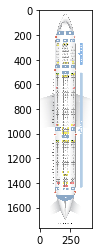

Pipeline start : 
Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


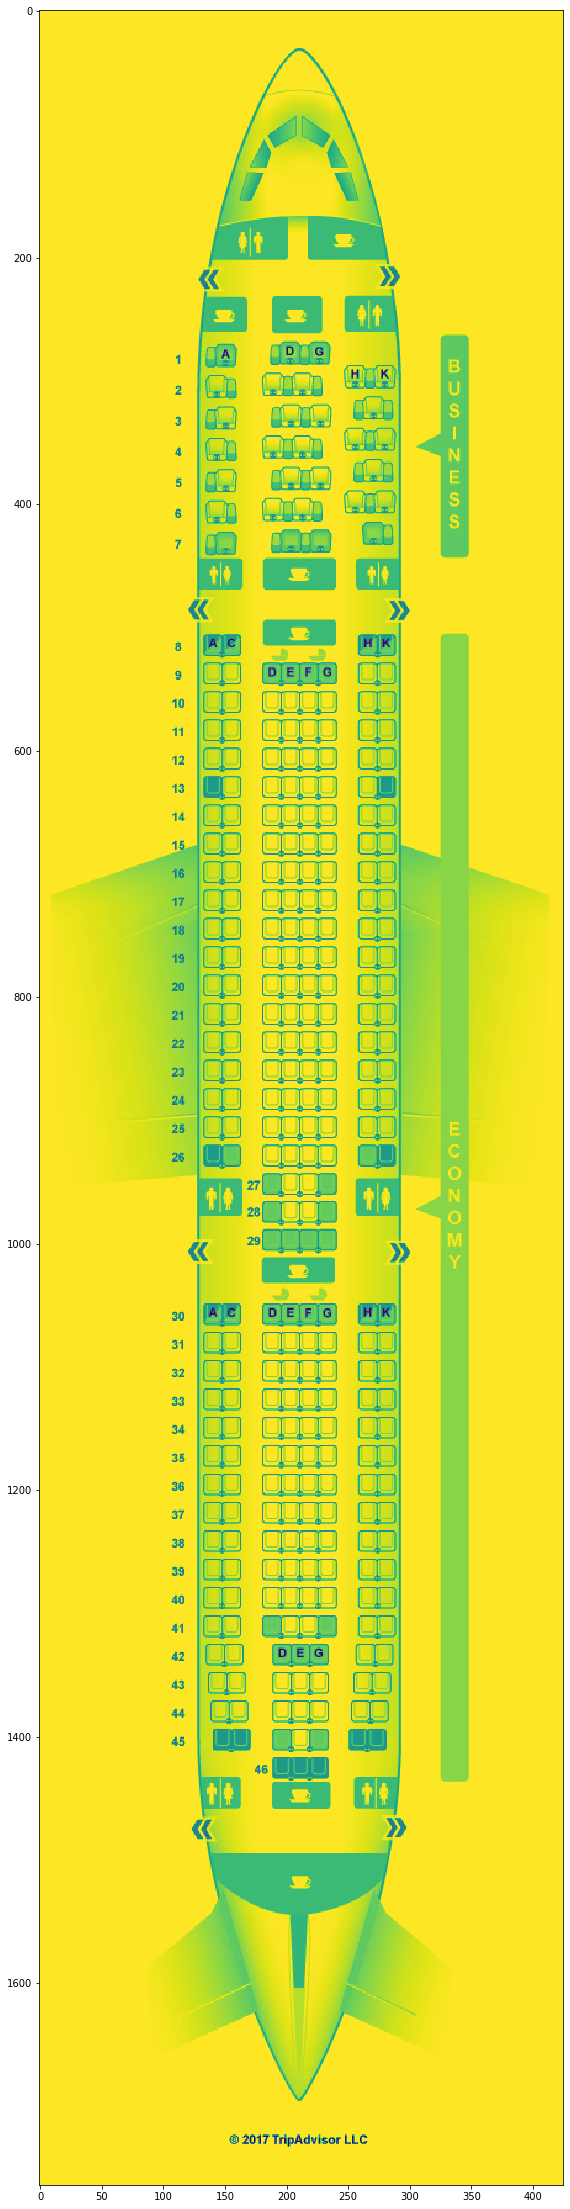

Process :  OpenCV4.1.2.30 -> Pattern Matching seat
Doing : OpenCV4.1.2.30 -> Pattern Matching seat
{'Aer_Lingus_Airbus_A330-300_A_plane6.jpg': {'BUSINESS': [(181, 294, 20, 18), (205, 294, 20, 18), (181, 345, 20, 18), (205, 345, 20, 18), (135, 296, 20, 18), (262, 313, 20, 18), (135, 347, 20, 18), (181, 396, 20, 18), (262, 364, 20, 18), (219, 370, 20, 18), (205, 396, 20, 18), (142, 372, 20, 18), (248, 389, 20, 18), (135, 398, 20, 18), (195, 370, 20, 18), (271, 389, 20, 18), (142, 321, 20, 18), (196, 370, 20, 18), (135, 397, 20, 18), (181, 395, 20, 18), (263, 313, 20, 18), (143, 372, 20, 18), (248, 339, 20, 18), (247, 389, 20, 18), (219, 319, 20, 18), (219, 320, 20, 18), (205, 395, 20, 18), (263, 364, 20, 18), (271, 339, 20, 18), (262, 415, 20, 18), (219, 421, 20, 18), (143, 321, 20, 18), (248, 338, 20, 18), (205, 345, 20, 18), (205, 396, 20, 18), (205, 294, 20, 18), (181, 345, 20, 18), (181, 294, 20, 18), (181, 396, 20, 18), (248, 339, 20, 18), (135, 296, 20, 18), (196, 320, 20, 18), (13

In [5]:
pipeline.run_pipeline(1)

# Pipeline Zone

Standard Python >= 3.5 -> preprocess colours a été ajouté.
OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas a été ajouté.
Standard Python >= 3.5 -> preprocess colours
OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


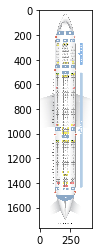

Pipeline start : 
Preprocess :  Standard Python >= 3.5 -> preprocess colours
Doing : Standard Python >= 3.5 -> preprocess colours


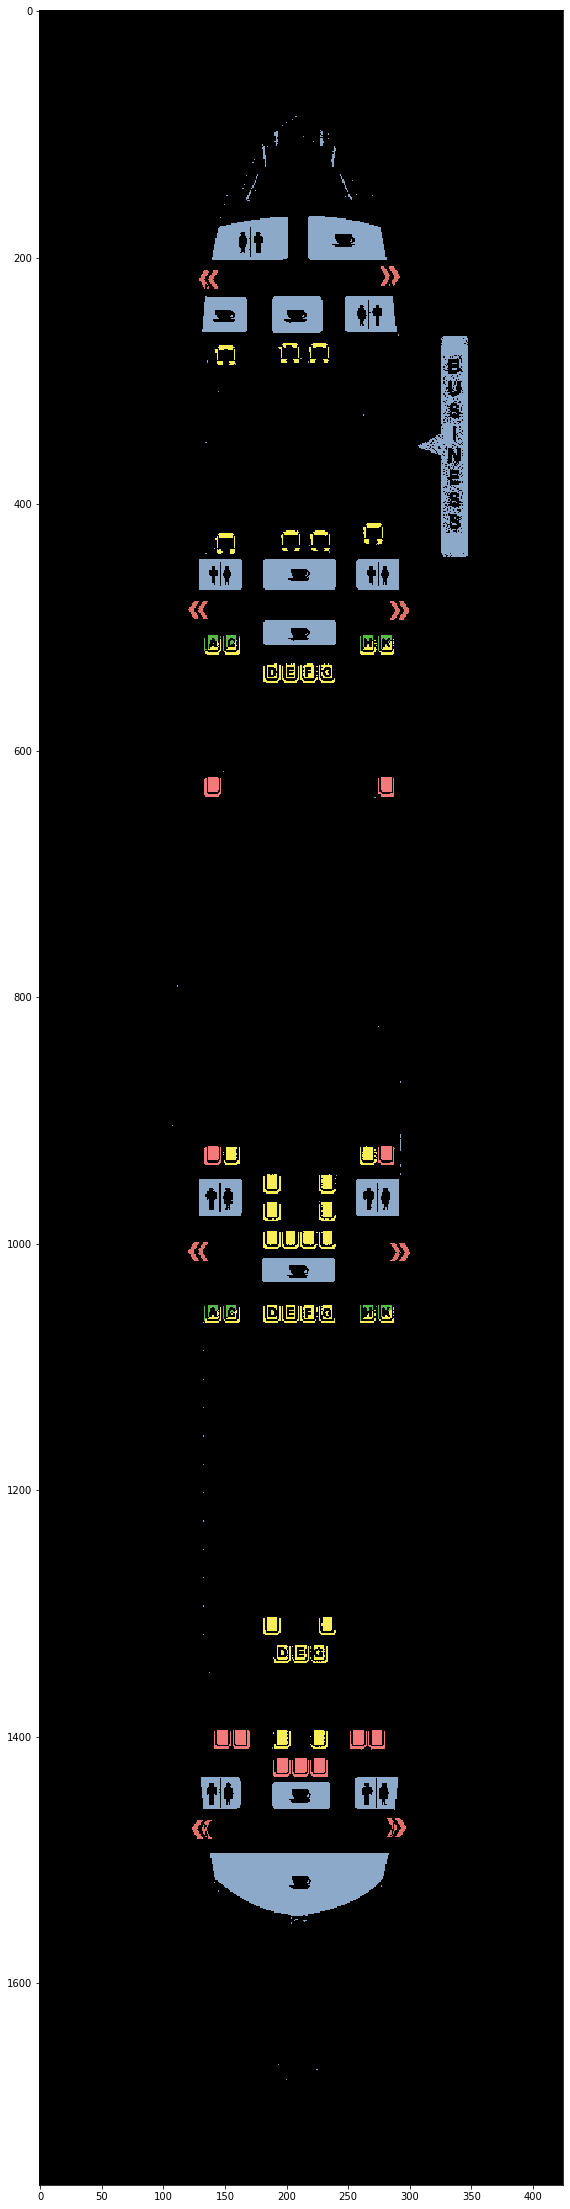

Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


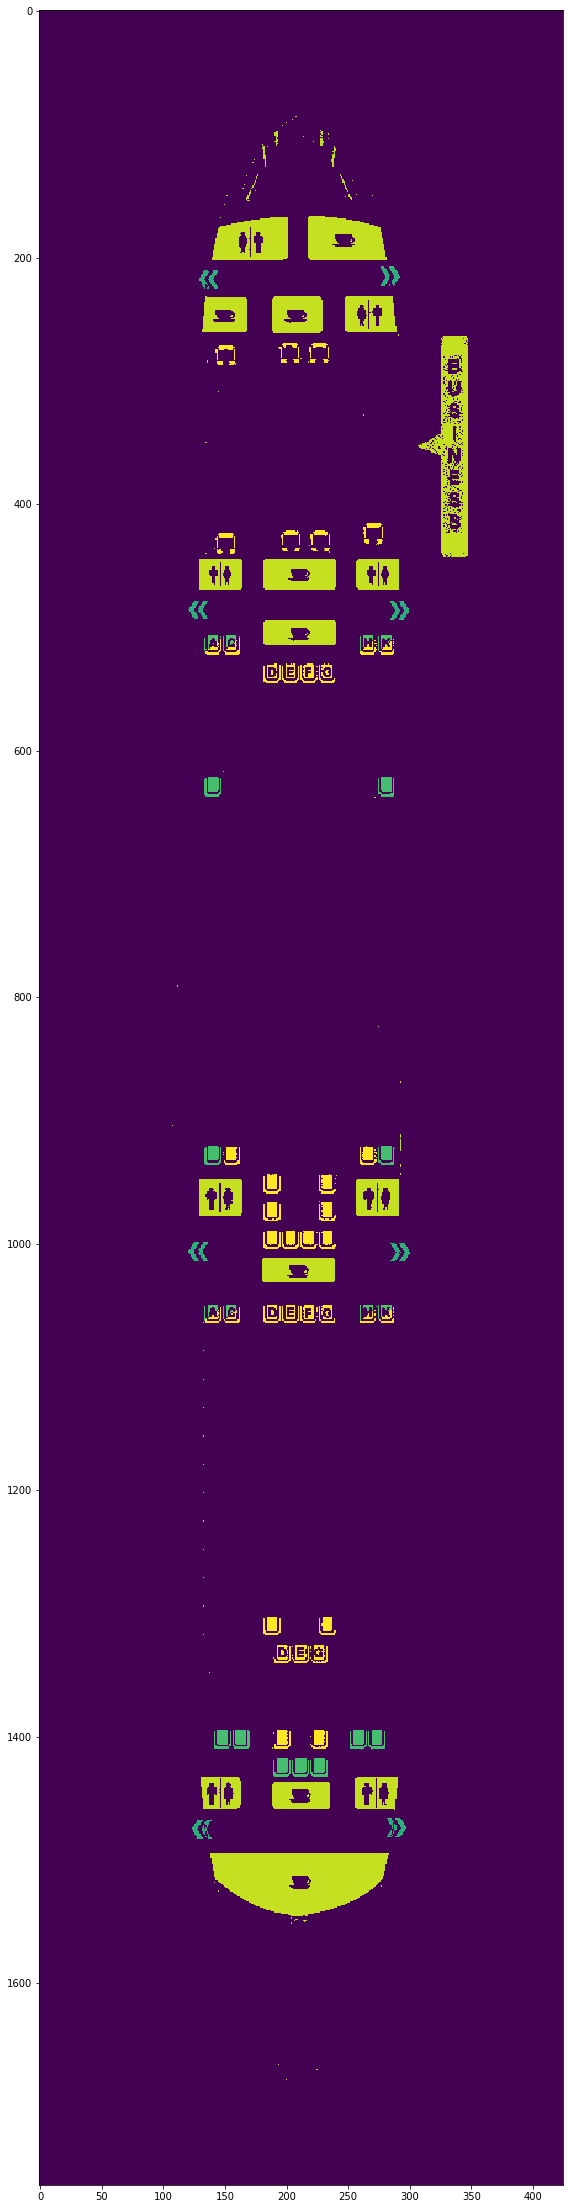

Process :  OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Doing : OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


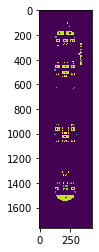

['bar4.png', 'bar5.png', 'sortie_droit (2).png', 'sortie_droit.png', 'sortie_gauche (2).png', 'sortie_gauche.png', 'toilettes_2.png']
{'Aer_Lingus_Airbus_A330-300_A_plane6.jpg': {'bar4.png': [(167, 218, 203, 282), (232, 132, 261, 169), (232, 189, 262, 230), (445, 182, 470, 241), (495, 182, 515, 241), (1012, 181, 1032, 240), (1437, 189, 1459, 236), (1495, 139, 1548, 284)], 'bar5.png': [(167, 218, 203, 282), (232, 132, 261, 169), (232, 189, 262, 230), (445, 130, 470, 165), (445, 182, 470, 241), (445, 257, 470, 292), (1437, 189, 1459, 236), (1495, 139, 1548, 284)], 'sortie_droit (2).png': [], 'sortie_droit.png': [], 'sortie_gauche (2).png': [], 'sortie_gauche.png': [], 'toilettes_2.png': [(167, 218, 203, 282), (168, 140, 203, 202), (1495, 139, 1548, 284)]}}


In [7]:
pipeline_zone = Pipeline(base_data_path,["Aer_Lingus_Airbus_A330-300_A_plane6.jpg"])
pipeline_zone.add_processes([ColourPipelineZones, BlackWhite, SegmentationZone])
pipeline_zone.run_pipeline(1)

## Merge elements

In [ ]:
pipeline.json

In [ ]:
coucou = DistPipeline()
coucou.to_json_simple_distance(pipeline.json, stub_pipeline_json)